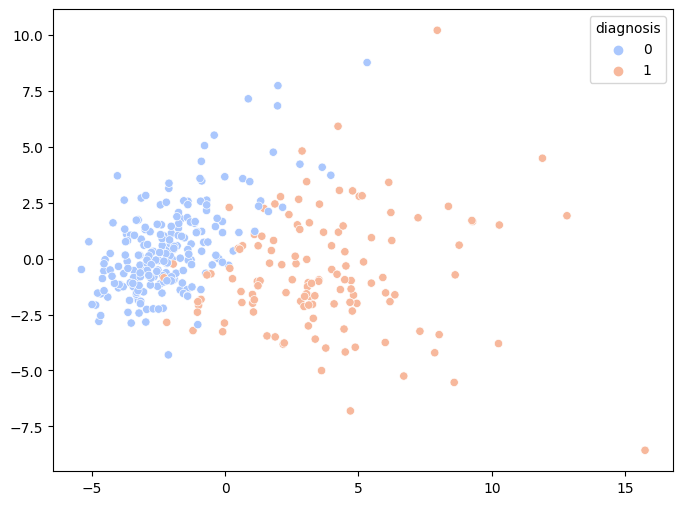

Best Regression Model: Ridge
Test MSE: 0.2076657891085037
Test MAE: 0.3613812195602345
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
           NeuralNetwork       SVM  RandomForest
accuracy        0.947368  0.982456      0.956140
precision       0.893617  0.976744      0.931818
recall          0.976744  0.976744      0.953488
f1              0.933333  0.976744      0.942529
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
Best Classifier: NeuralNetwork
{'accuracy': 0.9298245614035088, 'precision': 0.8863636363636364, 'recall': 0.9285714285714286, 'f1': 0.9069767441860465}
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
           NeuralNetwork       SVM  RandomForest
accuracy        0.929825  0.973684      0.938596
precision       0.886364  0.975610      0.926829
recall          0.928571  0.952381      0.904762
f1              0.906977  0.963855      0.915663


In [4]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_squared_error, mean_absolute_error, accuracy_score, precision_score, recall_score, f1_score
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras

data = pd.read_csv("/kaggle/input/breast-cancer-wisconsin-data/data.csv")
data = data.drop(columns=["id","Unnamed: 32"])
y_reg = data["radius_mean"]
y_clf = data["diagnosis"].map({"M":1,"B":0})
X = data.drop(columns=["radius_mean","diagnosis"])

X_train, X_test, y_reg_train, y_reg_test, y_clf_train, y_clf_test = train_test_split(
    X, y_reg, y_clf, test_size=0.2, stratify=y_clf, random_state=42
)
X_train, X_val, y_reg_train, y_reg_val, y_clf_train, y_clf_val = train_test_split(
    X_train, y_reg_train, y_clf_train, test_size=0.25, stratify=y_clf_train, random_state=42
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

pca = PCA(n_components=0.95)
X_train_pca = pca.fit_transform(X_train_scaled)
X_val_pca = pca.transform(X_val_scaled)
X_test_pca = pca.transform(X_test_scaled)

pca_vis = PCA(n_components=2)
X_vis = pca_vis.fit_transform(X_train_scaled)
plt.figure(figsize=(8,6))
sns.scatterplot(x=X_vis[:,0], y=X_vis[:,1], hue=y_clf_train, palette="coolwarm")
plt.show()

models = {
    "LinearRegression": LinearRegression(),
    "Ridge": Ridge(),
    "Lasso": Lasso()
}
results_reg = {}

for name, model in models.items():
    model.fit(X_train_pca, y_reg_train)
    y_pred = model.predict(X_val_pca)
    mse = mean_squared_error(y_reg_val, y_pred)
    results_reg[name] = mse
best_model_name = min(results_reg, key=results_reg.get)
best_model = models[best_model_name]
best_model.fit(X_train_pca, y_reg_train)
y_pred_test = best_model.predict(X_test_pca)
print("Best Regression Model:", best_model_name)
print("Test MSE:", mean_squared_error(y_reg_test, y_pred_test))
print("Test MAE:", mean_absolute_error(y_reg_test, y_pred_test))

def build_nn(input_dim, hidden_units=64, lr=0.001):
    model = keras.Sequential([
        keras.Input(shape=(input_dim,)),
        keras.layers.Dense(hidden_units, activation="relu"),
        keras.layers.Dense(hidden_units, activation="relu"),
        keras.layers.Dense(1, activation="sigmoid")
    ])
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=lr), loss="binary_crossentropy", metrics=["accuracy"])
    return model

nn = build_nn(X_train_pca.shape[1])
nn.fit(X_train_pca, y_clf_train, validation_data=(X_val_pca, y_clf_val), epochs=50, batch_size=16, verbose=0)
y_val_pred_nn = (nn.predict(X_val_pca) > 0.5).astype(int)
nn_val_metrics = {
    "accuracy": accuracy_score(y_clf_val, y_val_pred_nn),
    "precision": precision_score(y_clf_val, y_val_pred_nn),
    "recall": recall_score(y_clf_val, y_val_pred_nn),
    "f1": f1_score(y_clf_val, y_val_pred_nn)
}

svm = GridSearchCV(SVC(), {"C":[0.1,1,10], "kernel":["linear","rbf"]}, scoring="recall", cv=3)
svm.fit(X_train_pca, y_clf_train)
y_val_pred_svm = svm.predict(X_val_pca)
svm_val_metrics = {
    "accuracy": accuracy_score(y_clf_val, y_val_pred_svm),
    "precision": precision_score(y_clf_val, y_val_pred_svm),
    "recall": recall_score(y_clf_val, y_val_pred_svm),
    "f1": f1_score(y_clf_val, y_val_pred_svm)
}

rf = GridSearchCV(RandomForestClassifier(), {"n_estimators":[50,100,200], "max_depth":[3,5,10]}, scoring="recall", cv=3)
rf.fit(X_train_pca, y_clf_train)
y_val_pred_rf = rf.predict(X_val_pca)
rf_val_metrics = {
    "accuracy": accuracy_score(y_clf_val, y_val_pred_rf),
    "precision": precision_score(y_clf_val, y_val_pred_rf),
    "recall": recall_score(y_clf_val, y_val_pred_rf),
    "f1": f1_score(y_clf_val, y_val_pred_rf)
}

val_results = pd.DataFrame({
    "NeuralNetwork": nn_val_metrics,
    "SVM": svm_val_metrics,
    "RandomForest": rf_val_metrics
})
print(val_results)

best_model_clf = "NeuralNetwork" if nn_val_metrics["recall"]>=max(svm_val_metrics["recall"], rf_val_metrics["recall"]) 
else ("SVM" if svm_val_metrics["recall"]>=rf_val_metrics["recall"] 
      else "RandomForest")

if best_model_clf=="NeuralNetwork":
    y_test_pred = (nn.predict(X_test_pca) > 0.5).astype(int)
elif best_model_clf=="SVM":
    y_test_pred = svm.predict(X_test_pca)
else:
    y_test_pred = rf.predict(X_test_pca)

test_metrics = {
    "accuracy": accuracy_score(y_clf_test, y_test_pred),
    "precision": precision_score(y_clf_test, y_test_pred),
    "recall": recall_score(y_clf_test, y_test_pred),
    "f1": f1_score(y_clf_test, y_test_pred)
}
print("Best Classifier:", best_model_clf)
print(test_metrics)

test_results = pd.DataFrame({
    "NeuralNetwork": {
        "accuracy": accuracy_score(y_clf_test, (nn.predict(X_test_pca) > 0.5).astype(int)),
        "precision": precision_score(y_clf_test, (nn.predict(X_test_pca) > 0.5).astype(int)),
        "recall": recall_score(y_clf_test, (nn.predict(X_test_pca) > 0.5).astype(int)),
        "f1": f1_score(y_clf_test, (nn.predict(X_test_pca) > 0.5).astype(int))
    },
    "SVM": {
        "accuracy": accuracy_score(y_clf_test, svm.predict(X_test_pca)),
        "precision": precision_score(y_clf_test, svm.predict(X_test_pca)),
        "recall": recall_score(y_clf_test, svm.predict(X_test_pca)),
        "f1": f1_score(y_clf_test, svm.predict(X_test_pca))
    },
    "RandomForest": {
        "accuracy": accuracy_score(y_clf_test, rf.predict(X_test_pca)),
        "precision": precision_score(y_clf_test, rf.predict(X_test_pca)),
        "recall": recall_score(y_clf_test, rf.predict(X_test_pca)),
        "f1": f1_score(y_clf_test, rf.predict(X_test_pca))
    }
})
print(test_results)
